## Importing all the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import SMOTE

## Reading the data

In [ ]:
df = pd.read_excel('MG_data.xlsx')
display(df)

,Alloy,Tg,Tx,Tl,TEN,VA,d,Sm,Dmax
0,Ti50Cu42.5Ni7.5,670.0,708.0,1226.0,1.76,13.27,0.10,7.90,0.2
1,Zr70Al8Cu19Ni3,630.0,689.0,1200.0,1.48,18.38,0.13,7.92,0.2
2,Zr70Al8Cu3Ni19,640.0,710.0,1220.0,1.48,18.11,0.15,8.05,0.2
3,Ag46.2Mg15.4Ca38.4,407.0,439.0,809.0,1.48,16.48,0.10,8.79,0.3
4,Ag53.8Mg7.7Ca30.8Cu7.7,428.0,488.0,843.0,1.59,15.55,0.10,9.45,0.3
...,...,...,...,...,...,...,...,...,...
436,Mg59.5Cu22.9Ag6.6Gd11,425.0,472.0,734.0,1.47,13.50,0.13,9.47,27.0
437,Pd2Zr48Cu34Al8Ag8,699.0,794.0,1140.0,1.61,15.89,0.14,10.73,30.0
438,Ni4Zr48Cu32Al8Ag8,693.0,788.0,1129.0,1.61,15.79,0.15,11.17,30.0
439,Zr46Cu31.64Ag8.36Al8Be6,702.0,797.0,1103.0,1.60,15.26,0.17,11.85,35.0


In [ ]:
X = df.drop(['Alloy', 'Dmax'], axis=1).to_numpy()
y = df['Dmax'].to_numpy()

print(X.shape, y.shape)

(441, 7) (441,)


## Data Preprocessing and EDA

In [ ]:
print(df.isnull().sum())

Alloy    0
Tg       0
Tx       0
Tl       0
TEN      0
VA       0
d        0
Sm       0
Dmax     0
dtype: int64


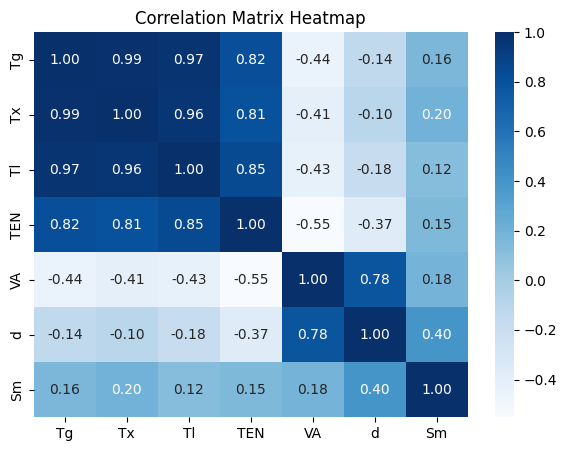

In [ ]:
corr_matrix = np.corrcoef(df.drop(['Alloy', 'Dmax'], axis=1), rowvar=False)

column_names = df.drop(['Alloy', 'Dmax'], axis=1).columns

plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f", xticklabels=column_names, yticklabels=column_names)
plt.title('Correlation Matrix Heatmap')
plt.show()

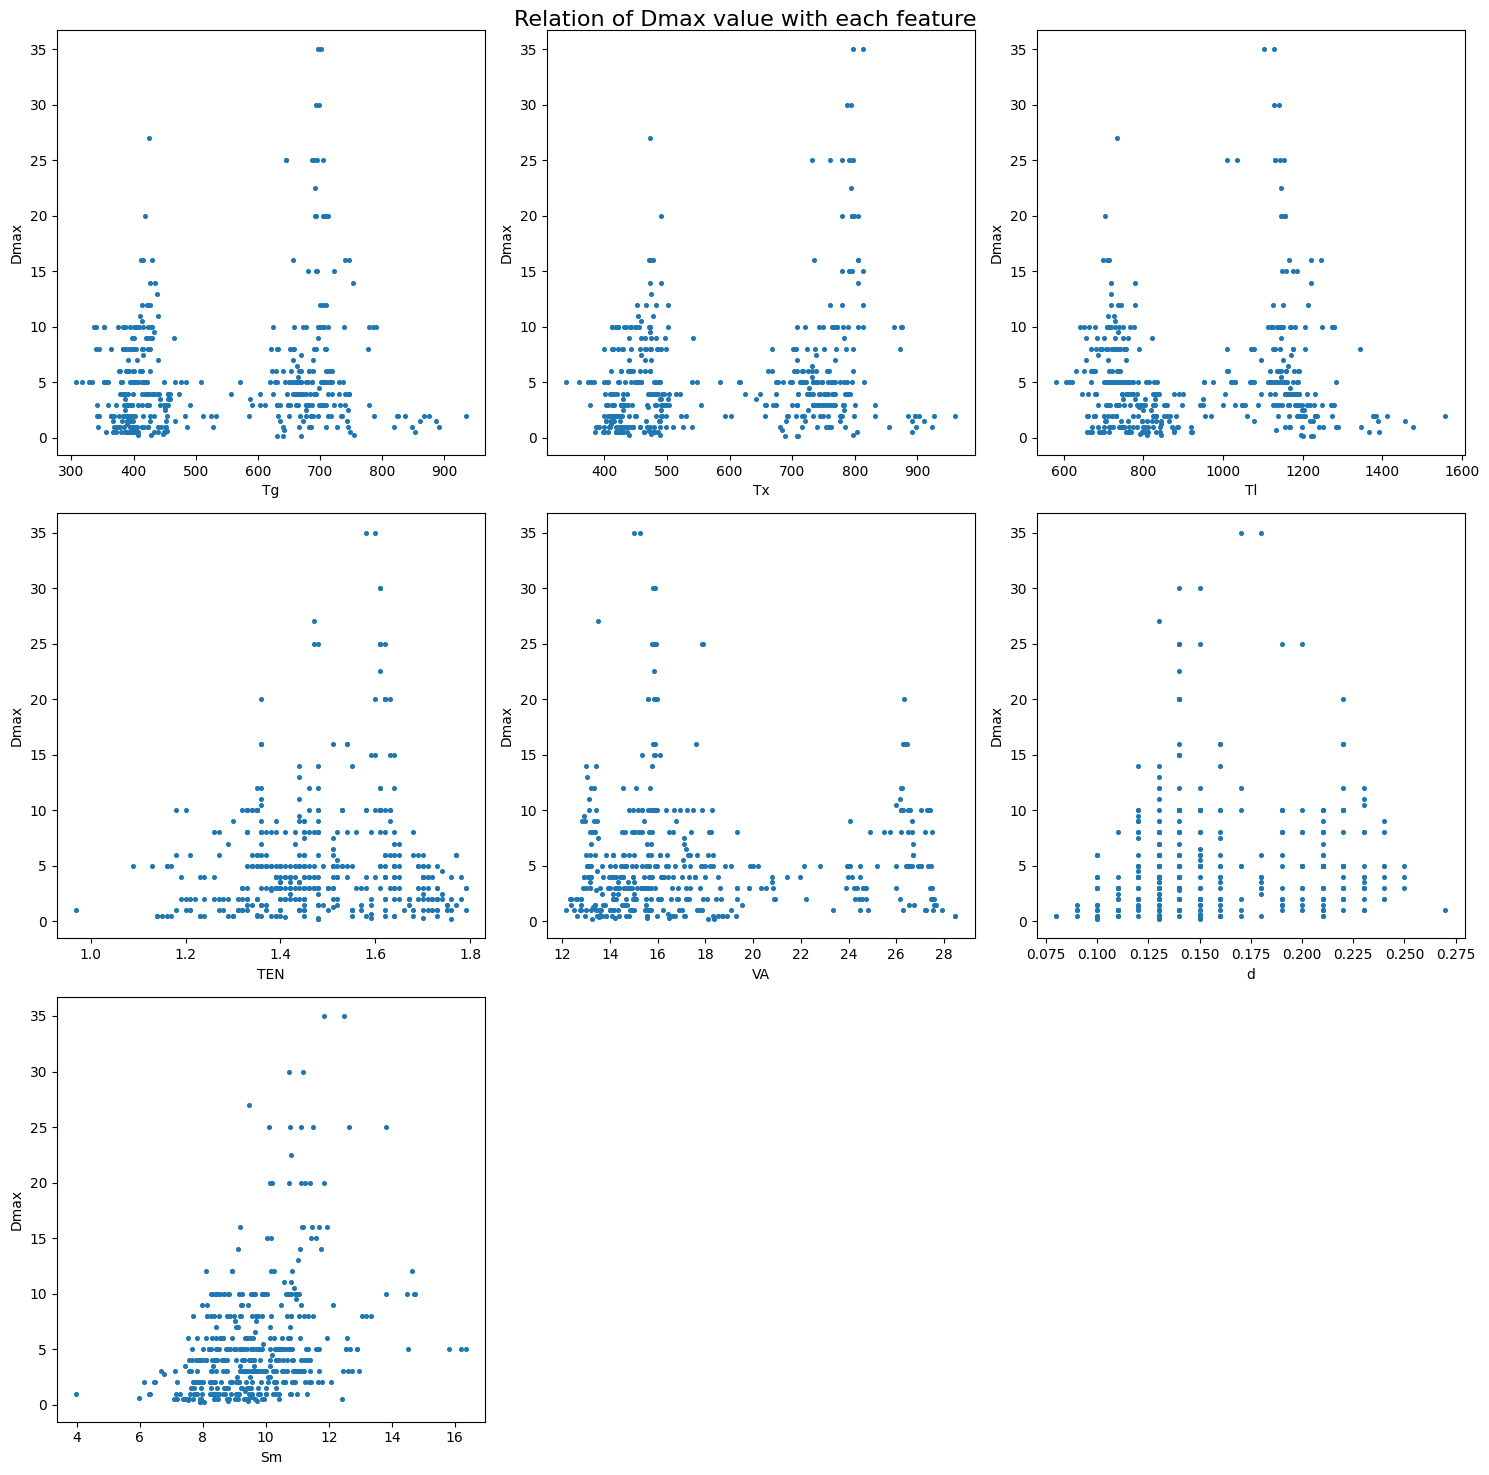

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))  # Create subplots

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        feature_index = i * 3 + j
        if feature_index < X.shape[1]:  # Check if feature index is within bounds
            ax.scatter(X[:, feature_index], y, alpha=1, s=7)  # Plot feature against y
            ax.set_xlabel(df.columns[feature_index+1])  # Set x-axis label
            ax.set_ylabel('Dmax')  # Set y-axis label
        else:
            ax.axis('off')  # Turn off empty subplots

plt.suptitle('Relation of Dmax value with each feature', fontsize=16)
plt.tight_layout()
plt.show()

### PCA and Normalisation

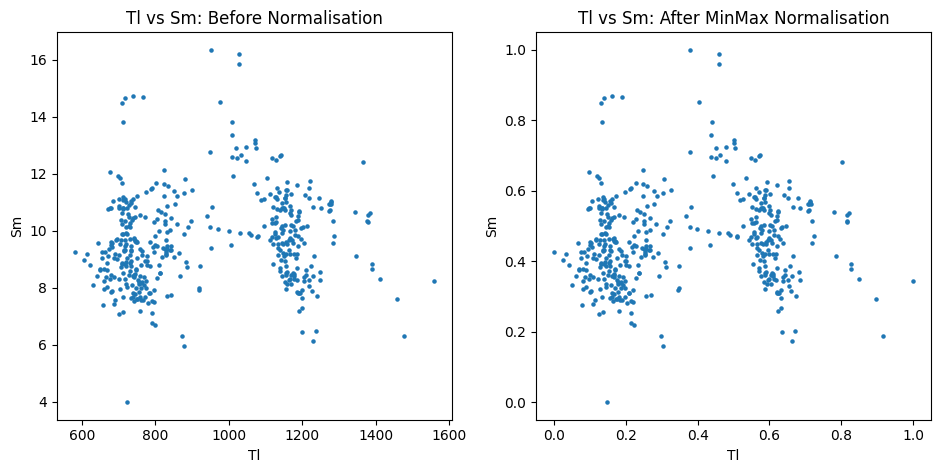

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3.0)

axes[0].scatter(X[:,2], X[:,-1], s=5)
axes[0].set_title('Tl vs Sm: Before Normalisation')
axes[0].set_xlabel('Tl')
axes[0].set_ylabel('Sm')

min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X)

axes[1].scatter(X_minmax[:, 2], X_minmax[:,-1], s=5)
axes[1].set_title('Tl vs Sm: After MinMax Normalisation')
axes[1].set_xlabel('Tl')
axes[1].set_ylabel('Sm')

plt.show()

In [ ]:
X_new = df[['Tl', 'TEN', 'VA', 'd', 'Sm']].values
pca_scaler = StandardScaler()
X_scaled = pca_scaler.fit_transform(X_new)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

print("New dimensions after PCA:", X_pca.shape)

print("Percentage of variance explained by each of the selected components:", pca.explained_variance_ratio_)

df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
display(df_pca)

Explained Variance Ratio: [0.52060445 0.29764612]
New dimensions after PCA: (441, 2)
Percentage of variance explained by each of the selected components: [0.52060445 0.29764612]


,PC1,PC2
0,-2.814067,-0.403834
1,-0.871014,-0.506830
2,-0.710240,-0.198171
3,-0.558217,-1.321825
4,-1.075997,-0.775094
...,...,...
436,-0.332720,-0.998175
437,-1.206233,0.840923
438,-1.056620,1.112269
439,-0.764213,1.526585


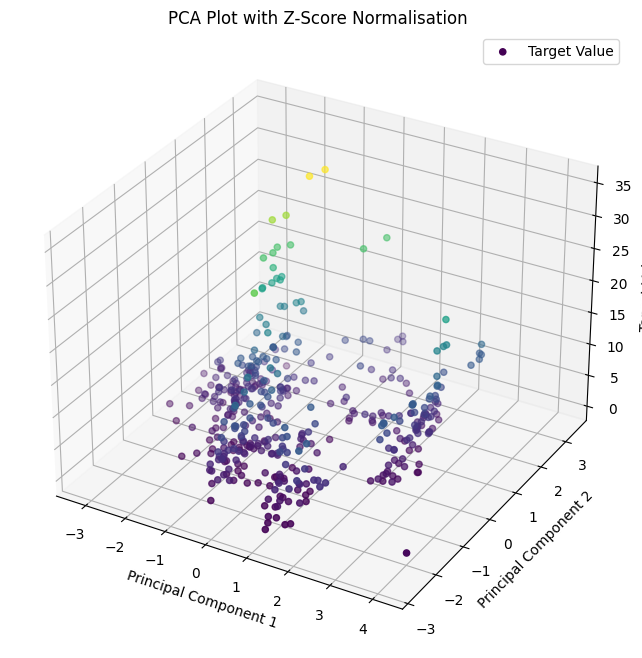

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# Plotting PCA-transformed data with target variable
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting points with target variable as the third dimension
ax.scatter(X_pca[:, 0], X_pca[:, 1], y, c=y, cmap='viridis', label='Target Value')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Target Value')
ax.set_title('PCA Plot with Z-Score Normalisation')
ax.legend()

plt.show()

In [ ]:
import plotly.graph_objects as go

# Create trace for scatter plot
scatter_trace = go.Scatter3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=y,
    mode='markers',
    marker=dict(
        size=5,
        color=y,
        colorscale='Viridis',
        opacity=0.9
    ),
    text=y
)

# Create layout for the plot
layout = go.Layout(
    title='PCA Plot with Z-Score Normalisation',
    scene=dict(
        xaxis=dict(title='Principal Component 1'),
        yaxis=dict(title='Principal Component 2'),
        zaxis=dict(title='Target Value')
    )
)

fig = go.Figure(data=[scatter_trace], layout=layout)

fig.show()

Explained Variance Ratio: [0.6223798  0.24814506]
New dimensions after PCA: (441, 2)
Percentage of variance explained by each of the selected components: [0.6223798  0.24814506]


,PC1,PC2
0,-0.578343,-0.080043
1,-0.145824,-0.087487
2,-0.119413,-0.147131
3,-0.131504,0.266322
4,-0.234921,0.189366
...,...,...
436,-0.152923,0.291150
437,-0.255245,-0.153574
438,-0.230273,-0.178190
439,-0.189039,-0.208832


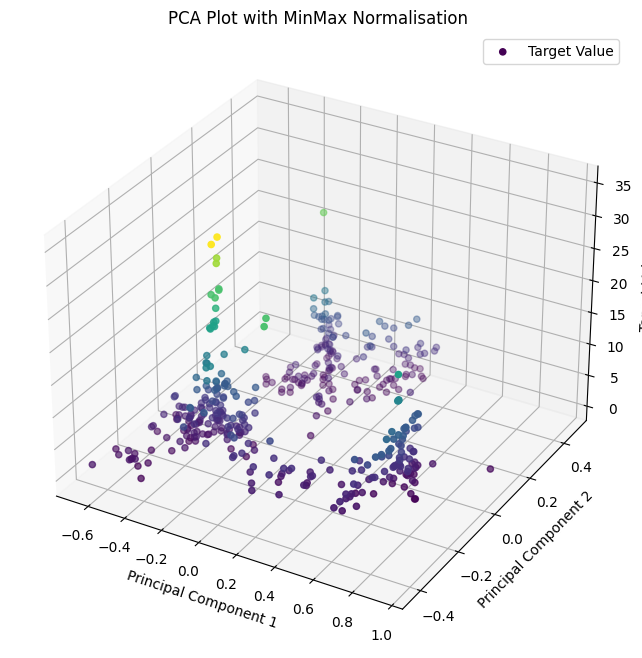

In [ ]:
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X)

X_new = df[['Tl', 'TEN', 'VA', 'd', 'Sm']].values
pca_scaler = MinMaxScaler()
X_scaled = pca_scaler.fit_transform(X_new)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

print("New dimensions after PCA:", X_pca.shape)

print("Percentage of variance explained by each of the selected components:", pca.explained_variance_ratio_)

df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
display(df_pca)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X_pca[:, 0], X_pca[:, 1], y, c=y, cmap='viridis', label='Target Value')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Target Value')
ax.set_title('PCA Plot with MinMax Normalisation')
ax.legend()

plt.show()

### Data Augmentation

In [ ]:
X_final = df[['Tl', 'TEN', 'VA', 'd', 'Sm']].to_numpy()
y_final = df['Dmax'].to_numpy()

#### Noise Addition

In [ ]:
def augmentation(X, y, num_augmented_samples_per_sample=3):
    augmented_X = []
    augmented_y = []

    for i in range(len(X)):
        original_sample = X[i]
        original_target = y[i]

        for _ in range(num_augmented_samples_per_sample):
            noise = np.random.normal(loc=0.0, scale=0.1, size=original_sample.shape)
            augmented_sample = original_sample + noise
            augmented_X.append(augmented_sample)
            augmented_y.append(original_target)

    augmented_X = np.vstack(augmented_X)
    augmented_y = np.array(augmented_y)
    return augmented_X, augmented_y

augmented_X, augmented_y = augmentation(X_final, y_final)
print("Original X shape:", X_final.shape)
print("Augmented X shape:", augmented_X.shape)
print("Augmented y shape:", augmented_y.shape)

Original X shape: (441, 5)
Augmented X shape: (1323, 5)
Augmented y shape: (1323,)


#### SMOTE

In [ ]:
aug_X, aug_y = augmentation(X_final, y_final, 4)

le = LabelEncoder()
y_final_encoded = le.fit_transform(aug_y)

# Check the class distribution before SMOTE
print("Class distribution before SMOTE:", {class_label: count for class_label, count in zip(le.classes_, np.bincount(y_final_encoded))})

smote = SMOTE(random_state=42, k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(aug_X, y_final_encoded)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:", {class_label: count for class_label, count in zip(le.classes_, np.bincount(y_resampled))})

y_resampled = le.inverse_transform(y_resampled)

print(X_resampled.shape, y_resampled.shape)

Class distribution before SMOTE: {0.2: 12, 0.3: 12, 0.4: 4, 0.5: 100, 0.6: 4, 0.68: 4, 1.0: 148, 1.25: 4, 1.5: 64, 2.0: 176, 2.5: 16, 2.8: 4, 3.0: 196, 3.5: 20, 4.0: 172, 4.5: 4, 5.0: 236, 5.5: 4, 6.0: 92, 6.5: 4, 7.0: 20, 7.5: 8, 8.0: 112, 9.0: 32, 9.5: 4, 10.0: 140, 10.5: 4, 11.0: 8, 12.0: 28, 13.0: 4, 14.0: 12, 15.0: 16, 16.0: 24, 20.0: 28, 22.5: 4, 25.0: 24, 27.0: 4, 30.0: 8, 35.0: 8}
Class distribution after SMOTE: {0.2: 236, 0.3: 236, 0.4: 236, 0.5: 236, 0.6: 236, 0.68: 236, 1.0: 236, 1.25: 236, 1.5: 236, 2.0: 236, 2.5: 236, 2.8: 236, 3.0: 236, 3.5: 236, 4.0: 236, 4.5: 236, 5.0: 236, 5.5: 236, 6.0: 236, 6.5: 236, 7.0: 236, 7.5: 236, 8.0: 236, 9.0: 236, 9.5: 236, 10.0: 236, 10.5: 236, 11.0: 236, 12.0: 236, 13.0: 236, 14.0: 236, 15.0: 236, 16.0: 236, 20.0: 236, 22.5: 236, 25.0: 236, 27.0: 236, 30.0: 236, 35.0: 236}
(9204, 5) (9204,)


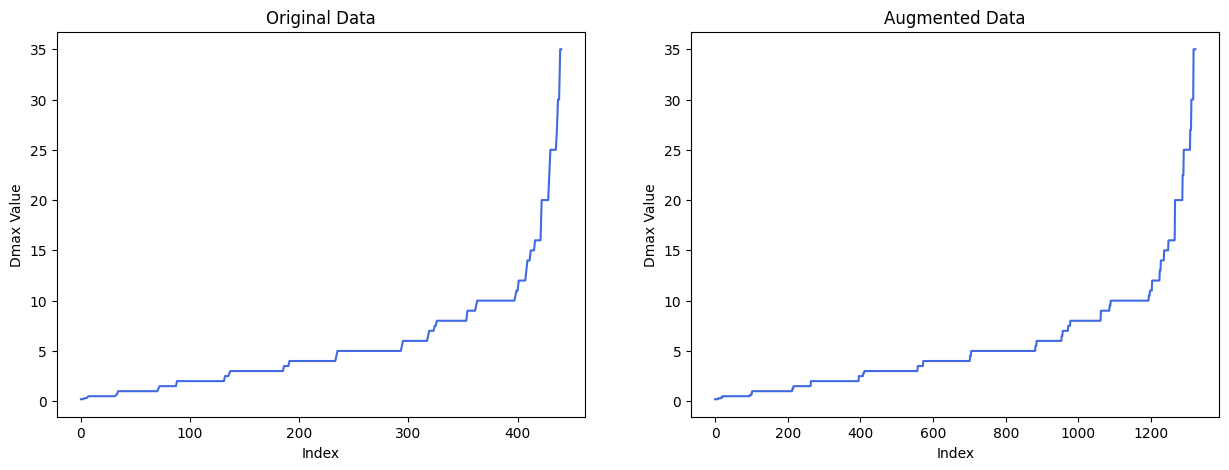

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(range(len(y)), y, c="royalblue")
axs[0].set_title('Original Data')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Dmax Value')

axs[1].plot(range(len(augmented_y)), augmented_y, c="royalblue")
axs[1].set_title('Augmented Data')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Dmax Value')

plt.show()

### Feature Importance

In [ ]:
model = RandomForestRegressor()
model.fit(X, y)

importances = model.feature_importances_

sorted_indices = np.argsort(importances)[::-1]

for idx in sorted_indices:
    print(f"Feature {idx}: {importances[idx]}")

Feature 1: 0.24442043218243176
Feature 6: 0.18956579679611754
Feature 2: 0.16118775851493783
Feature 0: 0.15987379738265303
Feature 4: 0.10737727360353841
Feature 3: 0.0940642857258101
Feature 5: 0.043510655794511424


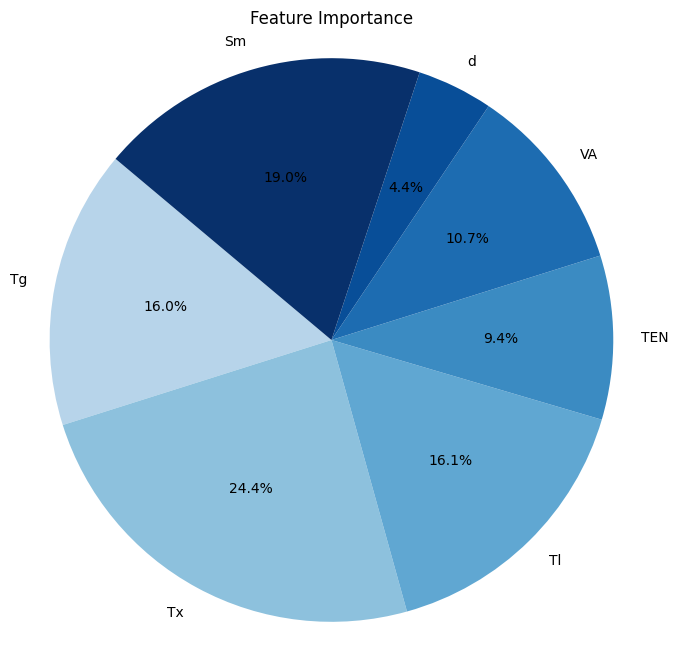

In [ ]:
num_slices = len(importances)
colors = plt.cm.Blues(np.linspace(0.3, 1, num_slices))


plt.figure(figsize=(8, 8))
plt.pie(importances, labels=df.columns[1:-1], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Feature Importance')
plt.axis('equal')

plt.show()

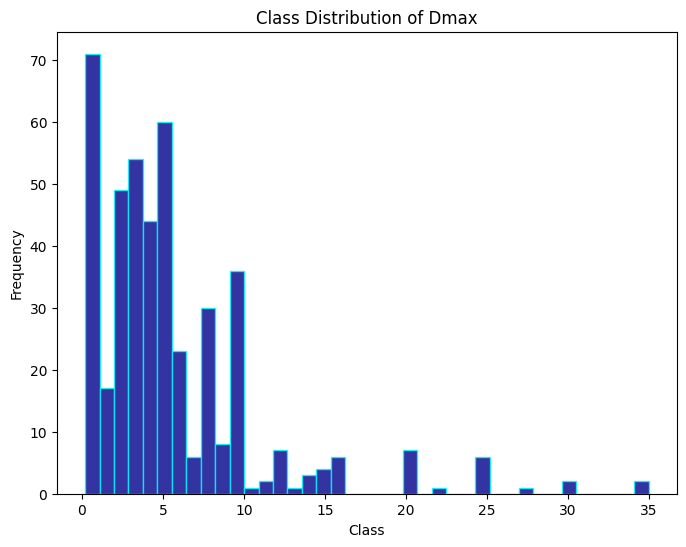

In [ ]:
plt.figure(figsize=(8, 6))

plt.hist(y_final, bins=len(set(y_final)), color='darkblue', edgecolor='cyan', alpha=0.8)

plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution of Dmax')

plt.show()

## Model

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def train(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred_train)
  rmse_train = np.sqrt(mse_train)
  mae_train = mean_absolute_error(y_train, y_pred_train)
  mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
  r2_train = r2_score(y_train, y_pred_train)

  y_pred = model.predict(X_test)
  mse_test = mean_squared_error(y_test, y_pred)
  rmse_test = np.sqrt(mse_test)
  mae_test = mean_absolute_error(y_test, y_pred)
  mape_test = mean_absolute_percentage_error(y_test, y_pred)
  r2_test = r2_score(y_test, y_pred)

  return  mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test

### XGBoost

In [ ]:
xgb_matrices = []

#### Training with the original Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test = train(xgb_model, X_train, X_test, y_train, y_test)

xgb_matrices.append(['Original', 'None', mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test])

##### After Normalisation

In [ ]:
# Apply MinMax normalization
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

# Apply Z-score normalization
zscore_scaler = StandardScaler()
X_train_zscore = zscore_scaler.fit_transform(X_train)
X_test_zscore = zscore_scaler.transform(X_test)

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train and evaluate model with MinMax normalization
mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test = train(xgb_model, X_train_minmax, X_test_minmax, y_train, y_test)

xgb_matrices.append(['Original', 'MinMax', mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test])

# Train and evaluate model with Z-score normalization
mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test = train(xgb_model, X_train_zscore, X_test_zscore, y_train, y_test)

xgb_matrices.append(['Original', 'Z-Score', mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test])

#### Training with Augmented Data

In [ ]:
augmented_X, augmented_y = augmentation(X_final, y_final, 5)
X_train, X_test, y_train, y_test = train_test_split(augmented_X, augmented_y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test = train(xgb_model, X_train, X_test, y_train, y_test)

xgb_matrices.append(['Augmented', 'None', mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test])

##### After Normalisation

In [ ]:
# Apply MinMax normalization
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

# Apply Z-score normalization
zscore_scaler = StandardScaler()
X_train_zscore = zscore_scaler.fit_transform(X_train)
X_test_zscore = zscore_scaler.transform(X_test)

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train and evaluate model with MinMax normalization
mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test = train(xgb_model, X_train_minmax, X_test_minmax, y_train, y_test)

xgb_matrices.append(['Augmented', 'MinMax', mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test])

# Train and evaluate model with Z-score normalization
mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test = train(xgb_model, X_train_zscore, X_test_zscore, y_train, y_test)

xgb_matrices.append(['Augmented', 'Z-Score', mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test])

#### Training with SMOTE resampled data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             random_state=42,
                             reg_alpha=1,
                             reg_lambda=20)
mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test = train(xgb_model, X_train, X_test, y_train, y_test)

xgb_matrices.append(['SMOTE Resampled', 'None', mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test])

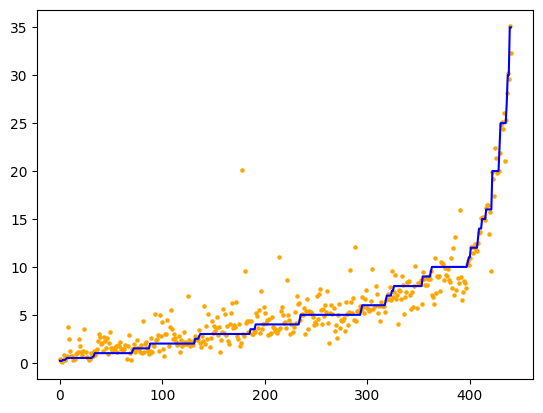

In [ ]:
plt.scatter(range(len(y_final)), xgb_model.predict(X_final), color='orange', s=5)
plt.plot(range(len(y_final)), y_final, color='blue')
plt.show()

##### After Normalisation

In [ ]:
# Apply MinMax normalization
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

# Apply Z-score normalization
zscore_scaler = StandardScaler()
X_train_zscore = zscore_scaler.fit_transform(X_train)
X_test_zscore = zscore_scaler.transform(X_test)

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train and evaluate model with MinMax normalization
mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test = train(xgb_model, X_train_minmax, X_test_minmax, y_train, y_test)

xgb_matrices.append(['SMOTE Resampled', 'MinMax', mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test])

# Train and evaluate model with Z-score normalization
mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test = train(xgb_model, X_train_zscore, X_test_zscore, y_train, y_test)

xgb_matrices.append(['SMOTE Resampled', 'Z-Score', mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test])

#### Accuracy Matrices for XGBoost

In [ ]:
columns = pd.MultiIndex.from_tuples([('', 'Data'), ('', 'Normalisation'), ('Train set', 'MSE'), ('Train set', 'RMSE'), ('Train set', 'MAE'), ('Train set', 'MAPE'), ('Train set', 'R2 Score'),
                                     ('Test set', 'MSE'), ('Test set', 'RMSE'), ('Test set', 'MAE'), ('Test set', 'MAPE'), ('Test set', 'R2 Score')])

xgb_df = pd.DataFrame(xgb_matrices, columns=columns)
display(xgb_df)

Train set                                 \
              Data Normalisation       MSE      RMSE       MAE       MAPE   
0         Original          None  0.003727  0.061046  0.042174   1.636999   
1         Original        MinMax  0.003727  0.061046  0.042174   1.636999   
2         Original       Z-Score  0.003727  0.061046  0.042174   1.636999   
3        Augmented          None  0.081886  0.286158  0.199890   8.413155   
4        Augmented        MinMax  0.081886  0.286158  0.199890   8.413155   
5        Augmented       Z-Score  0.081886  0.286158  0.199890   8.413155   
6  SMOTE Resampled          None  0.251911  0.501907  0.249806  10.283586   
7  SMOTE Resampled        MinMax  0.067676  0.260147  0.141433   6.663303   
8  SMOTE Resampled       Z-Score  0.065551  0.256029  0.139128   6.448800   

              Test set                                            
   R2 Score        MSE      RMSE       MAE        MAPE  R2 Score  
0  0.999856  22.768326  4.771617  2.578333  117.806915  0.484408  
1  0.999856  22.768326  4.771617  2.578333  117.806915  0.484408  
2  0.999856  22.768326  4.771617  2.578333  117.806915  0.484408  
3  0.997289   4.615035  2.148263  1.278199   44.263568  0.829828  
4  0.997289   4.615035  2.148263  1.278199   44.263568  0.829828  
5  0.997289   4.615035  2.148263  1.278199   44.263568  0.829828  
6  0.996748   1.075268  1.036951  0.443956   18.211155  0.986832  
7  0.999126   1.030136  1.014956  0.373200   15.792979  0.987384  
8  0.999154   0.999278  0.999639  0.367350   15.831235  0.987762

### Other models

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
linear_reg_pred = linear_reg.predict(X_test)
linear_reg_mse = mean_squared_error(y_test, linear_reg_pred)
linear_reg_mape = mean_absolute_percentage_error(y_test, linear_reg_pred)

# Ridge Regression
ridge_reg = Ridge(alpha=1)
ridge_reg.fit(X_train, y_train)
ridge_reg_pred = ridge_reg.predict(X_test)
ridge_reg_mse = mean_squared_error(y_test, ridge_reg_pred)
ridge_reg_mape = mean_absolute_percentage_error(y_test, ridge_reg_pred)

# Polynomial Regression
poly_features = PolynomialFeatures(degree=3)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
poly_reg_pred = poly_reg.predict(X_test_poly)
poly_reg_mse = mean_squared_error(y_test, poly_reg_pred)
poly_reg_mape = mean_absolute_percentage_error(y_test, poly_reg_pred)

# Support Vector Regression (SVR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
svr = SVR(kernel='rbf')
svr.fit(X_train_scaled, y_train)
svr_pred = svr.predict(X_test_scaled)
svr_mse = mean_squared_error(y_test, svr_pred)
svr_mape = mean_absolute_percentage_error(y_test, svr_pred)

# XGBoost
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)

# Print the mean squared error for each model
print("Linear Regression MSE:", linear_reg_mse, "MAPE:", linear_reg_mape)
print("Ridge Regression MSE:", ridge_reg_mse, "MAPE:", ridge_reg_mape)
print("Polynomial Regression MSE:", poly_reg_mse, "MAPE:", poly_reg_mape)
print("SVR MSE:", svr_mse, "MAPE:", svr_mape)
print("XGBoost MSE:", xgb_mse, "MAPE:", xgb_mape)

Linear Regression MSE: 37.8599755179516 MAPE: 196.1406960839249
Ridge Regression MSE: 37.857431532326736 MAPE: 195.818683654517
Polynomial Regression MSE: 33.168073779018165 MAPE: 176.21137239652313
SVR MSE: 35.83018983015876 MAPE: 120.76969577218905
XGBoost MSE: 22.768326489145963 MAPE: 117.8069148389058


### Comparative Study

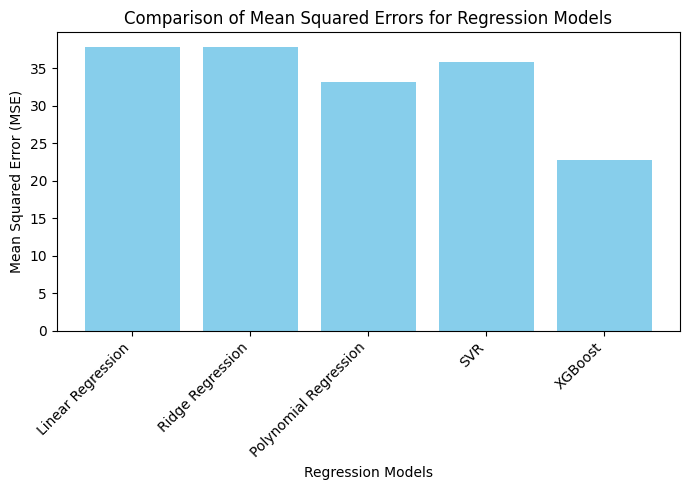

In [ ]:
mse_list = [linear_reg_mse, ridge_reg_mse, poly_reg_mse, svr_mse, xgb_mse]
models = ['Linear Regression', 'Ridge Regression', 'Polynomial Regression', 'SVR', 'XGBoost']

plt.figure(figsize=(7, 5))
plt.bar(models, mse_list, color='skyblue')
plt.xlabel('Regression Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Mean Squared Errors for Regression Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<h1><center>RESULTS</center></h1>

## Final Model: XGBoost with SMOTE resampled data

In [ ]:
def final_model(X_resampled, y_resampled, test_size=0.2):
  X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

  min_max_scaler = MinMaxScaler()
  X_train_minmax = min_max_scaler.fit_transform(X_train)
  X_test_minmax = min_max_scaler.transform(X_test)

  xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                              reg_alpha=1,
                              reg_lambda=20)

  return list(train(xgb_model, X_train_minmax, X_test_minmax, y_train, y_test))

In [ ]:
final_model_matrix = []

for i in range(10):
  final_model_matrix.append(final_model(X_resampled, y_resampled, test_size=0.2))


matrices_cols = pd.MultiIndex.from_tuples([('Train set', 'MSE'), ('Train set', 'RMSE'), ('Train set', 'MAE'), ('Train set', 'MAPE'), ('Train set', 'R2 Score'),
                                     ('Test set', 'MSE'), ('Test set', 'RMSE'), ('Test set', 'MAE'), ('Test set', 'MAPE'), ('Test set', 'R2 Score')])

matrices_df = pd.DataFrame(final_model_matrix, columns=matrices_cols)
display(matrices_df)

Train set                                           Test set            \
        MSE      RMSE       MAE       MAPE  R2 Score       MSE      RMSE   
0  0.325242  0.570300  0.281052  12.363061  0.995860  0.971014  0.985400   
1  0.325914  0.570889  0.280248  12.247030  0.995769  0.782781  0.884749   
2  0.277191  0.526489  0.258191  10.632884  0.996419  1.151015  1.072854   
3  0.283964  0.532883  0.262205  10.848112  0.996327  0.863412  0.929200   
4  0.252485  0.502479  0.245185  10.655187  0.996774  1.265778  1.125068   
5  0.260214  0.510111  0.256306  11.174609  0.996704  0.761704  0.872757   
6  0.254259  0.504241  0.247580  10.604155  0.996756  1.006739  1.003364   
7  0.286041  0.534828  0.262496  10.472476  0.996361  0.794834  0.891534   
8  0.320173  0.565839  0.285391  12.441978  0.995947  0.985231  0.992588   
9  0.362345  0.601951  0.301905  12.915238  0.995367  1.200229  1.095550   

                                  
        MAE       MAPE  R2 Score  
0  0.452339  18.807370  0.987435  
1  0.423567  19.584313  0.990601  
2  0.429620  15.586003  0.985924  
3  0.403254  17.013611  0.989499  
4  0.446711  18.715560  0.983877  
5  0.398819  14.499320  0.989941  
6  0.432181  16.762689  0.987086  
7  0.392265  15.548265  0.989691  
8  0.436168  18.754417  0.986928  
9  0.443859  17.199800  0.984748

In [ ]:
display(matrices_df.describe())

Train set                                               Test set  \
             MSE       RMSE        MAE       MAPE   R2 Score        MSE   
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    0.294783   0.542001   0.268056  11.435473   0.996228   0.978274   
std     0.036871   0.033628   0.018278   0.943180   0.000475   0.180935   
min     0.252485   0.502479   0.245185  10.472476   0.995367   0.761704   
25%     0.264458   0.514206   0.256778  10.638460   0.995882   0.811978   
50%     0.285003   0.533855   0.262351  11.011360   0.996344   0.978122   
75%     0.323975   0.569184   0.280851  12.334053   0.996633   1.114946   
max     0.362345   0.601951   0.301905  12.915238   0.996774   1.265778   

                                                   
            RMSE        MAE       MAPE   R2 Score  
count  10.000000  10.000000  10.000000  10.000000  
mean    0.985306   0.425878  17.247135   0.987573  
std     0.090952   0.021072   1.693529   0.002309  
min     0.872757   0.392265  14.499320   0.983877  
25%     0.900951   0.408332  15.880174   0.986175  
50%     0.988994   0.430900  17.106706   0.987261  
75%     1.055481   0.441937  18.744703   0.989643  
max     1.125068   0.452339  19.584313   0.990601